## RNN (using single step approch)

* Single-step approach predicts only the next step (t + delta t) and compares directly with actual values. 

* No feedback loop where predictions become inputs for the next step. 

* More precise evaluation since predictions are independently tested against y_test

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [2]:
# Load dataset
train_data = pd.read_csv('TE1.csv')
test_data = pd.read_csv('TR1.csv')

# Normalize `IP Delay (ms)`
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

print(train_data.head())  # Check the normalized data


     SN  IP Delay (ms)  Normalized IP Delay
0  9001      20.951986             0.839265
1  9002      20.885944             0.827640
2  9003      20.895958             0.829402
3  9004      20.812035             0.814630
4  9005      20.740986             0.802124


In [3]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Sequence of `sequence_length`
        y.append(data[i+sequence_length])   # Target value (next time step)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 10

# Prepare training sequences
train_values = train_data['Normalized IP Delay'].values
X_train, y_train = create_sequences(train_values, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Prepare testing sequences
test_values = test_data['Normalized IP Delay'].values
X_test, y_test = create_sequences(test_values, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (3490, 10, 1)
y_train Shape: (3490,)
X_test Shape: (8990, 10, 1)
y_test Shape: (8990,)


Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0283 - val_loss: 0.0079
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - val_loss: 0.0092
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0080 - val_loss: 0.0080
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0057 - val_loss: 0.0087
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0073 - val_loss: 0.0083
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0075 - val_loss: 0.0082
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0071 - val_loss: 0.0082
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0075 - val_loss: 0.0084
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.

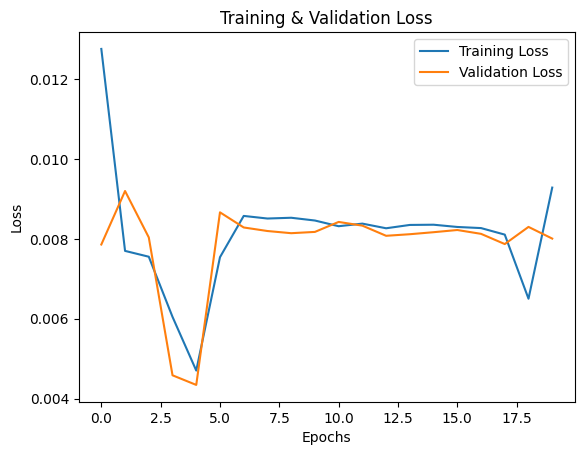

In [4]:
# Define model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),  # RNN Layer
    Dense(1)  # Single output for next step prediction
])

# Compile with optimized hyperparameters
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [5]:
# Predict single-step delay for each sequence
single_step_predictions = model.predict(X_test)

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(single_step_predictions)

# Denormalize actual values
denormalized_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 125) & (comparison_df['SN'] <= 175)]

#  Print filtered DataFrame
print(comparison_df_filtered)


281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
124  125              18.204927                 18.189064            0.015863
125  126              18.204927                 18.074606            0.130322
126  127              18.220901                 18.049450            0.171452
127  128              18.082142                 18.069120            0.013021
128  129              18.108130                 17.953129            0.155001
129  130              17.943144                 17.943605            0.000462
130  131              17.950058                 17.804796            0.145262
131  132              17.831087                 17.787718            0.043369
132  133              17.795801                 17.678551            0.117250
133  134              17.668962                 17.635380            0.033583
134  135              17.683029                 17.507078            0.175951
135  136              1

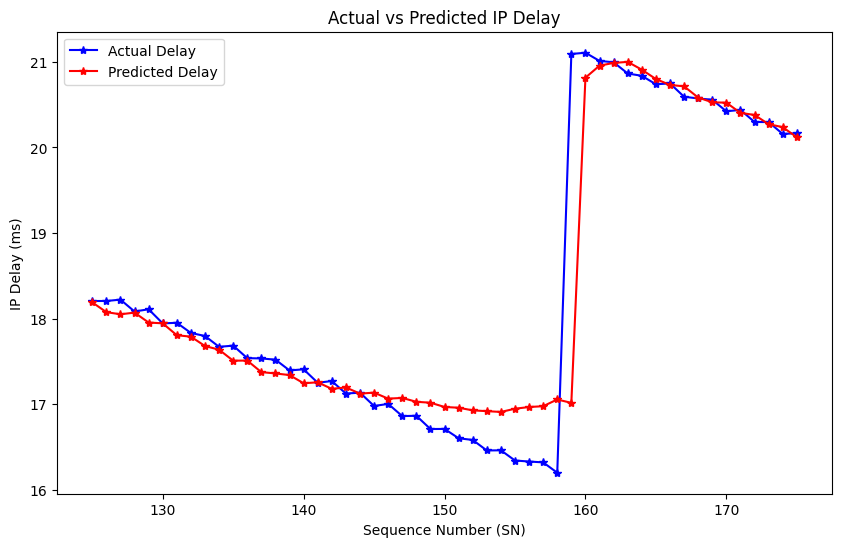

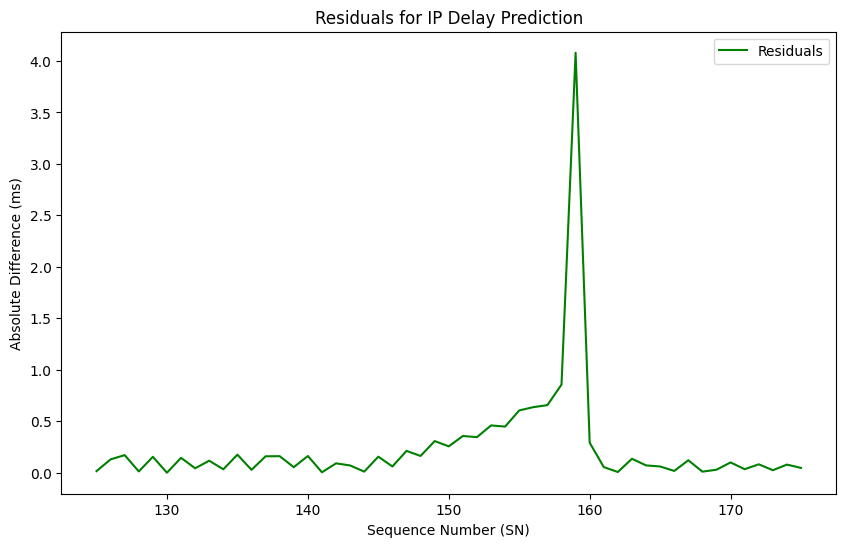

In [6]:

#  Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay',marker='*', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay',marker='*', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay')
plt.legend()
plt.show()

#  Plot residuals 
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction')
plt.legend()



### We tried to optimize our results by adjusting the values of Sequence Length, Learning rate, EPOCH Count, Batch Size, Validation split etc. 

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler


In [8]:
# Load dataset
train_data = pd.read_csv('TE1.csv')
test_data = pd.read_csv('TR1.csv')

# Normalize `IP Delay (ms)`
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

print(train_data.head())  # Check the normalized data


     SN  IP Delay (ms)  Normalized IP Delay
0  9001      20.951986             0.839265
1  9002      20.885944             0.827640
2  9003      20.895958             0.829402
3  9004      20.812035             0.814630
4  9005      20.740986             0.802124


In [9]:
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])  # Sequence of `sequence_length`
        y.append(data[i+sequence_length])   # Target value (next time step)
    return np.array(X), np.array(y)

# Define sequence length
sequence_length = 20

# Prepare training sequences
train_values = train_data['Normalized IP Delay'].values
X_train, y_train = create_sequences(train_values, sequence_length)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Prepare testing sequences
test_values = test_data['Normalized IP Delay'].values
X_test, y_test = create_sequences(test_values, sequence_length)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("X_train Shape:", X_train.shape)
print("y_train Shape:", y_train.shape)
print("X_test Shape:", X_test.shape)
print("y_test Shape:", y_test.shape)


X_train Shape: (3480, 20, 1)
y_train Shape: (3480,)
X_test Shape: (8980, 20, 1)
y_test Shape: (8980,)


Epoch 1/50


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0446 - val_loss: 0.0124
Epoch 2/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0143 - val_loss: 0.0083
Epoch 3/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0064 - val_loss: 0.0055
Epoch 4/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0067 - val_loss: 0.0046
Epoch 5/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0048 - val_loss: 0.0043
Epoch 6/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0044 - val_loss: 0.0040
Epoch 7/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0036 - val_loss: 0.0037
Epoch 8/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 0.0047
Epoch 9/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0047
Epoch 10/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0046 - val_loss: 0.0036
Epoch 11/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_loss: 0.0044
Epoch 12/50
87/87 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0047 - val_loss: 0.0040


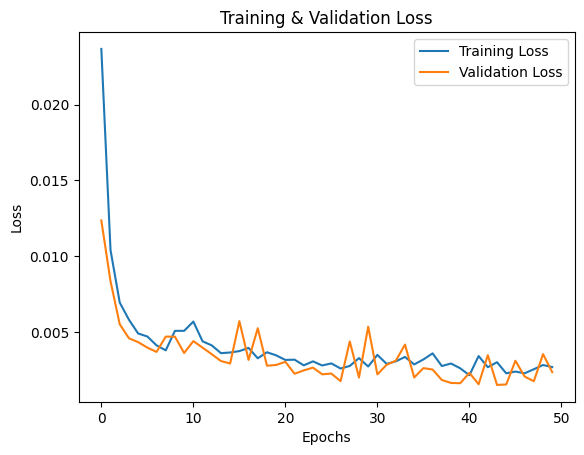

In [10]:
# Define model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(X_train.shape[1], 1)),  # RNN Layer
    Dense(1)  # Single output for next step prediction
])

# Compile with optimized hyperparameters
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mse')

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Plot training progress
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [11]:
# Predict single-step delay for each sequence
single_step_predictions = model.predict(X_test)

# Denormalize predictions
denormalized_predictions = scaler.inverse_transform(single_step_predictions)

# Denormalize actual values
denormalized_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN 
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 125) & (comparison_df['SN'] <= 175)]

#  Print filtered DataFrame
print(comparison_df_filtered)




281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
124  125              17.683029                 17.632368            0.050661
125  126              17.536879                 17.560188            0.023310
126  127              17.533064                 17.506670            0.026394
127  128              17.518997                 17.425873            0.093124
128  129              17.393112                 17.400873            0.007761
129  130              17.405987                 17.356323            0.049664
130  131              17.249107                 17.289808            0.040701
131  132              17.268896                 17.227242            0.041655
132  133              17.122984                 17.145584            0.022600
133  134              17.132998                 17.085005            0.047993
134  135              16.977072                 17.012888            0.035816
135  136              1

In [12]:
print(X_test)

[[[0.69456102]
  [0.49848917]
  [0.49567735]
  ...
  [0.79683566]
  [0.79490515]
  [0.77413127]]

 [[0.49848917]
  [0.49567735]
  [0.31626658]
  ...
  [0.79490515]
  [0.77413127]
  [0.77077388]]

 [[0.49567735]
  [0.31626658]
  [0.71990935]
  ...
  [0.77413127]
  [0.77077388]
  [0.75054558]]

 ...

 [[0.21755917]
  [0.2170136 ]
  [0.18918919]
  ...
  [0.03802249]
  [0.01846567]
  [0.01196072]]

 [[0.2170136 ]
  [0.18918919]
  [0.19116166]
  ...
  [0.01846567]
  [0.01196072]
  [0.87392983]]

 [[0.18918919]
  [0.19116166]
  [0.17584355]
  ...
  [0.01196072]
  [0.87392983]
  [0.8759023 ]]]


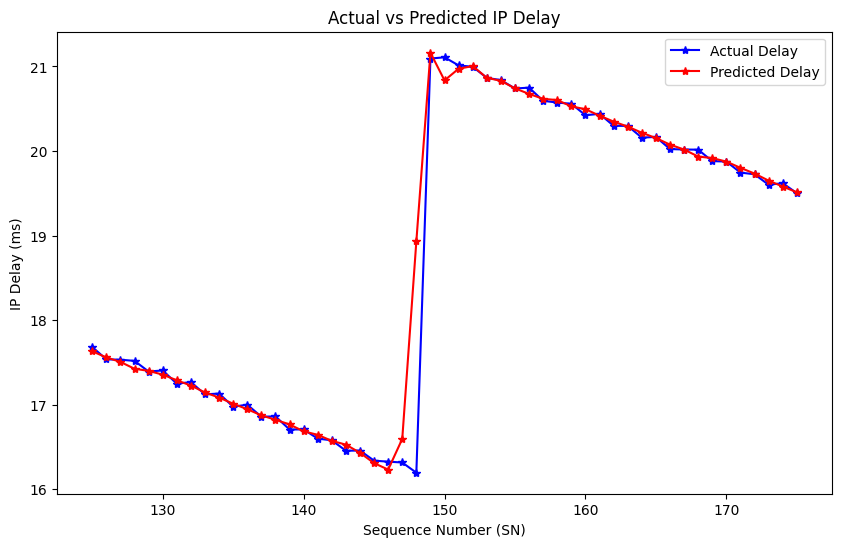

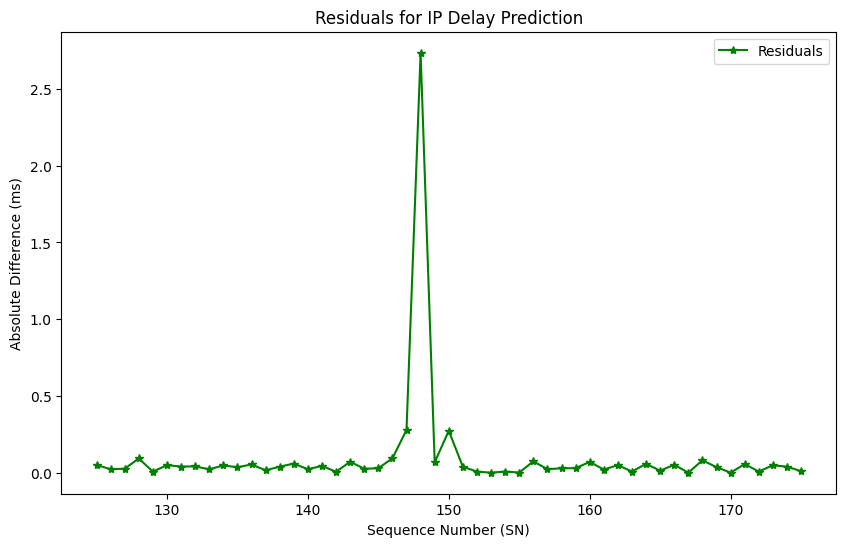

In [13]:
#  Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay',marker='*', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay',marker='*', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay')
plt.legend()
plt.show()

#  Plot residuals
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals', marker='*' ,color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction')
plt.legend()
plt.show()

# COMPARISON B/W VALUES AFTER THE ALTERING THE PARAMETERS 

### SEQUENCE LENGTH = 10, LEARNING RATE =0.01, EPOCHS =20, BATCH SIZE =16

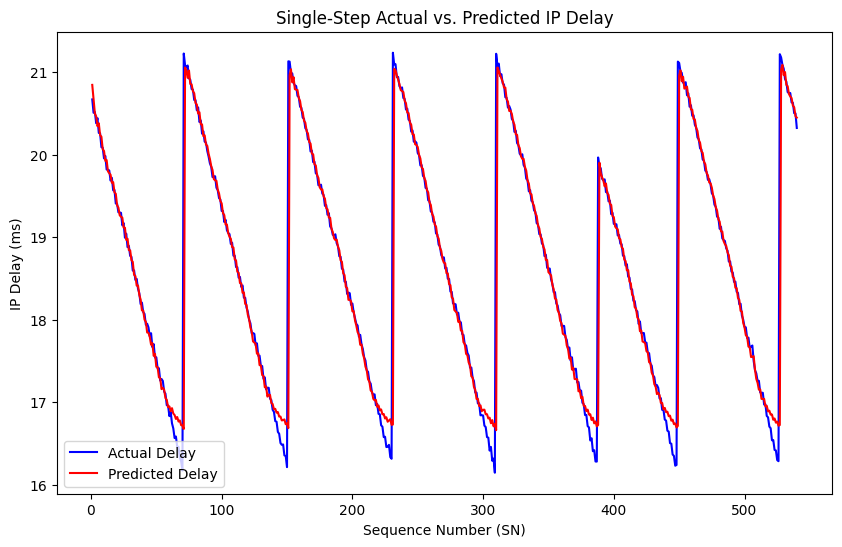

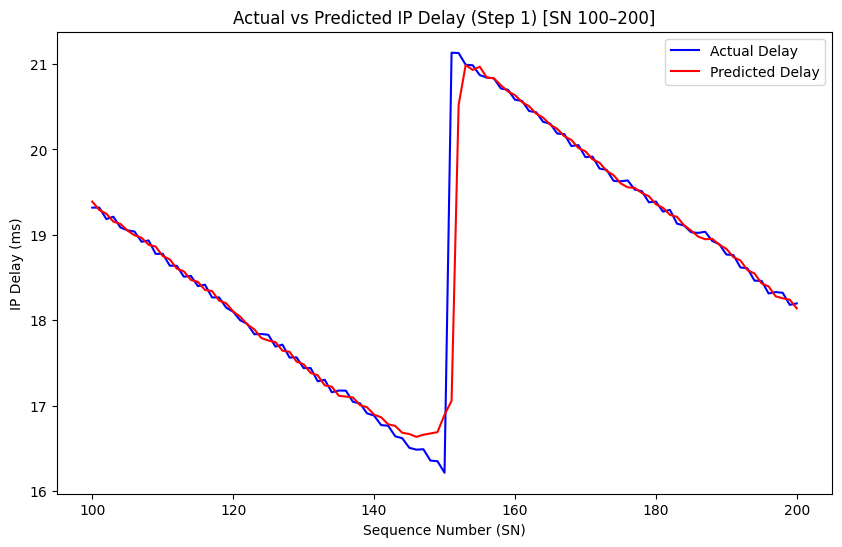

### SEQUENCE LENGTH = 20, LEARNING RATE =0.001, EPOCHS =50, BATCH SIZE =32

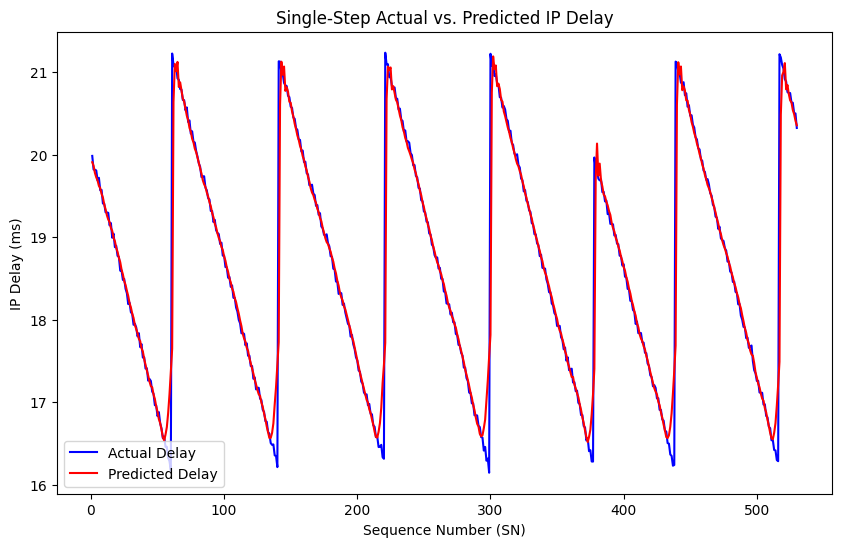


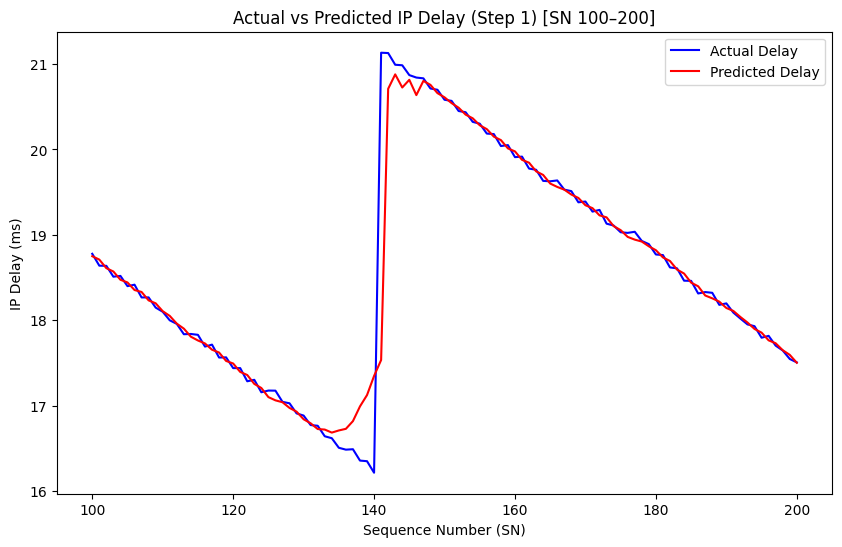

## Single step approch with multiple outputs           (Sequence-to-Sequence Approach)


* Predict the next k timesteps (e.g., t+1 to t+5) from one input sequence [t0...tN]
* No Feedback loop is used

Epoch 1/20


c:\ML\PYTHON\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


175/175 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0392 - val_loss: 0.0073
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - val_loss: 0.0065
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0049
Epoch 4/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0065 - val_loss: 0.0049
Epoch 5/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0050 - val_loss: 0.0031
Epoch 6/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0044 - val_loss: 0.0039
Epoch 7/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0055 - val_loss: 0.0036
Epoch 8/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0050 - val_loss: 0.0043
Epoch 9/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0049 - val_loss: 0.0028
Epoch 10/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0039 - val_loss: 0.0032
Epoch 11/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 12/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.

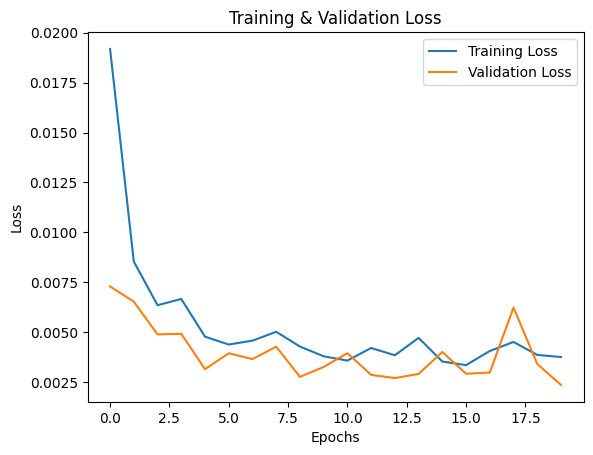

281/281 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
      SN  Actual Delay (Step 1)  Predicted Delay (Step 1)  Absolute Diff (ms)
124  125              18.204927                 18.274977            0.070049
125  126              18.204927                 18.183123            0.021805
126  127              18.220901                 18.141262            0.079639
127  128              18.082142                 18.135117            0.052975
128  129              18.108130                 18.061781            0.046349
129  130              17.943144                 18.034403            0.091259
130  131              17.950058                 17.927702            0.022356
131  132              17.831087                 17.882063            0.050976
132  133              17.795801                 17.797892            0.002090
133  134              17.668962                 17.744482            0.075520
134  135              17.683029                 17.647854            0.035175
135  136              1

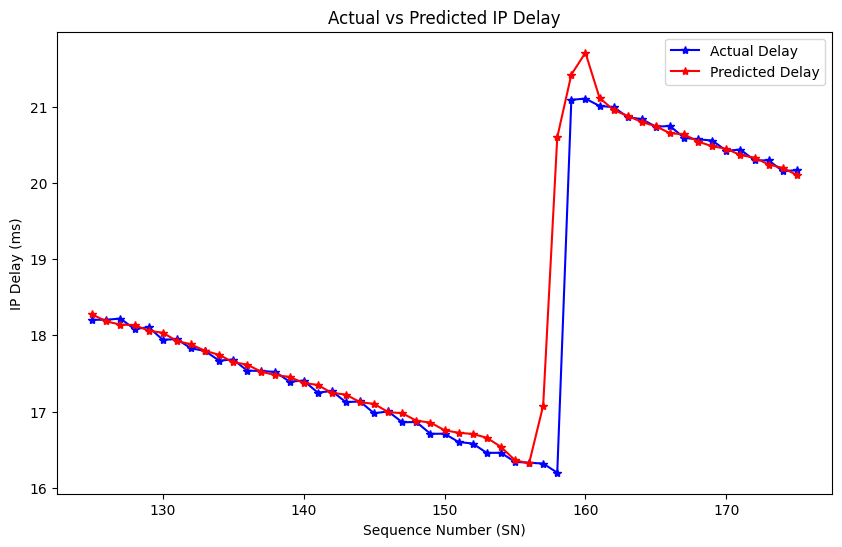

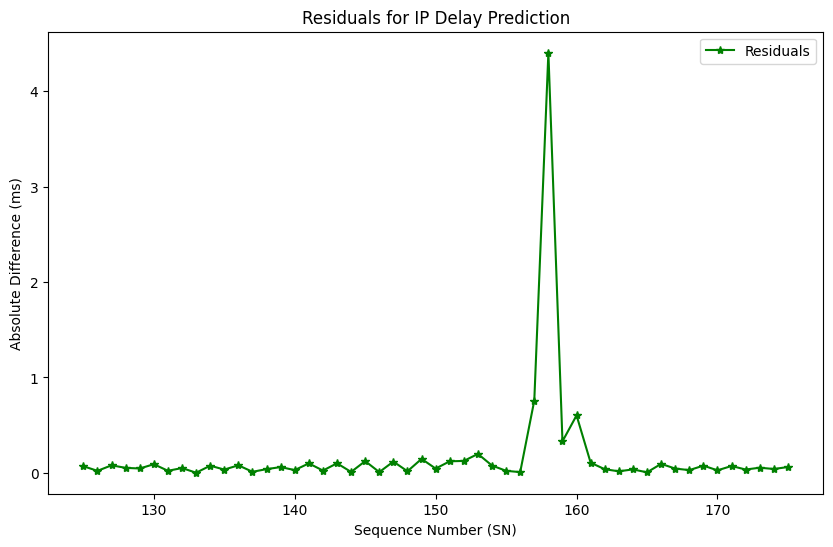

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# Load dataset
train_data = pd.read_csv('TE1.csv')
test_data = pd.read_csv('TR1.csv')

# Normalize IP Delay (ms)
scaler = MinMaxScaler(feature_range=(0, 1))
train_data['Normalized IP Delay'] = scaler.fit_transform(train_data[['IP Delay (ms)']])
test_data['Normalized IP Delay'] = scaler.transform(test_data[['IP Delay (ms)']])

# Set sequence length and output steps
sequence_length = 10  # Number of input timesteps
output_steps = 5      # Number of output timesteps

# Extract normalized values
train_values = train_data['Normalized IP Delay'].values
test_values = test_data['Normalized IP Delay'].values

# Function to create sequences
def create_seq2seq_sequences(data, input_len, output_len):
    X, y = [], []
    for i in range(len(data) - input_len - output_len):
        X.append(data[i:i+input_len])
        y.append(data[i+input_len:i+input_len+output_len])
    return np.array(X), np.array(y)

# Prepare training and test data
X_train, y_train = create_seq2seq_sequences(train_values, sequence_length, output_steps)
X_test, y_test = create_seq2seq_sequences(test_values, sequence_length, output_steps)

# Reshape inputs for RNN [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Reshape outputs [samples, output_steps]
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))

# Build model
model = Sequential([
    SimpleRNN(50, activation='relu', input_shape=(sequence_length, 1)),
    Dense(output_steps)
])

model.compile(optimizer=Adam(0.01), loss='mse')

# Train model
history = model.fit(X_train, y_train, epochs=20, batch_size=16, validation_split=0.2)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predict
predictions = model.predict(X_test)

# Denormalize predictions and ground truth
denormalized_predictions = scaler.inverse_transform(predictions)
denormalized_actual = scaler.inverse_transform(y_test)

# Compare actual vs predicted for first output step
comparison_df = pd.DataFrame({
    'SN': range(1, len(denormalized_actual) + 1),
    'Actual Delay (Step 1)': denormalized_actual[:, 0],
    'Predicted Delay (Step 1)': denormalized_predictions[:, 0],
    'Absolute Diff (ms)': np.abs(denormalized_actual[:, 0] - denormalized_predictions[:, 0])
})

#  Filter for SN
comparison_df_filtered = comparison_df[(comparison_df['SN'] >= 125) & (comparison_df['SN'] <= 175)]

#  Print filtered DataFrame
print(comparison_df_filtered)

#  Plot actual vs predicted 
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Actual Delay (Step 1)'], label='Actual Delay',marker='*', color='blue')
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Predicted Delay (Step 1)'], label='Predicted Delay',marker='*', color='red')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('IP Delay (ms)')
plt.title('Actual vs Predicted IP Delay')
plt.legend()
plt.show()

#  Plot residuals (SN 100–200)
plt.figure(figsize=(10, 6))
plt.plot(comparison_df_filtered['SN'], comparison_df_filtered['Absolute Diff (ms)'], label='Residuals',marker='*',color='green')
plt.xlabel('Sequence Number (SN)')
plt.ylabel('Absolute Difference (ms)')
plt.title('Residuals for IP Delay Prediction')
plt.legend()
plt.show()
